### Imports

In [193]:
import pandas as pd
import numpy as np
import os, sys
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import cv2
from keras.datasets import cifar10
from keras.utils import to_categorical
import SqueezeNet

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, datasets, models, losses, optimizers, metrics, utils, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as tf_ppimg

### Constant

In [194]:
IMGPATH = 'CIFAR10'
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
LBL = dict(zip(range(10), CLASSES))
IN_SHAPE = (32, 32, 3)

In [195]:
print(LBL)

{0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


### Loading CIFAR10 dataset batches

In [196]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
#         X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, f'data_batch_{b}')
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=45000, num_validation=5000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = os.path.join(os.getcwd(), 'CIFAR10')
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')

    x_train /= 255
    x_test /= 255    

    # Subsample the data
    mask = range(num_training, int(num_training) + int(num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_test, y_test, X_val, y_val

# Onehot 10 classes encoding
y_train_onehot = utils.to_categorical(y_train, num_classes=10)
y_val_onehot = utils.to_categorical(y_val, num_classes=10)
y_test_onehot = utils.to_categorical(y_test, num_classes=10)

### Loading Keras CIFAR10 dataset

In [197]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    trainX, testX = prep_pixels(trainX, testX)
    return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm


### Train Test Split

In [202]:
X_train, y_train, X_test, y_test = load_dataset()

In [203]:
print('Train - Test - Val: images shape:')
print(*list(zip(('x_train', 'y_train', 'x_test', 'y_test'), 
                map(lambda x: x.shape, (X_train, y_train, X_test, y_test)))), sep='\n')

Train - Test - Val: images shape:
('x_train', (50000, 32, 32, 3))
('y_train', (50000, 10))
('x_test', (10000, 32, 32, 3))
('y_test', (10000, 10))


### Plot Train Test samples

In [206]:
def plot_images(images, labels):        
    # inorder to view in imshow we need image of type (height, width, channel) rather than (channel, height, width)
    IMG = []
    for img in images:
        img_reshape = np.reshape(img,(3,32,32)) # get the first element from list
        IMG.append(np.transpose(img_reshape/255., (1,2,0)))
    fig = plt.figure(figsize=(8, 8))
    # plot image grid
    for x in range(5):
        for y in range(1):
            ax = fig.add_subplot(5, 5, 5*y+x+1)
            plt.imshow(images[y+x])
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
            labels = labels.flatten().astype(int) # to 1-D array for indexing
            plt.xlabel(CLASSES[labels[y+x]])
    plt.show()

Training images : 55000 images.


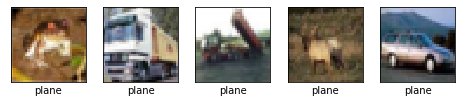

--------------------
Testing images : 10000 images.


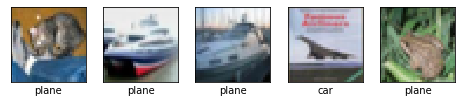

In [207]:
# Visualize CIFAR-10
print('Training images : ' + str(X_train.shape[0] + X_val.shape[0]) + ' images.')
plot_images(X_train[:5], y_train[:5])
print(20 * '-')
print('Testing images : ' + str(X_test.shape[0]) + ' images.')
plot_images(X_test[:5], y_test[:5])

### The Model

In [208]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    sq1x1 = "squeeze1x1"
    exp1x1 = "expand1x1"
    exp3x3 = "expand3x3"
    relu = "relu_"
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3

    x = layers.Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = layers.Activation('relu', name=s_id + relu + sq1x1)(x)

    left = layers.Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = layers.Activation('relu', name=s_id + relu + exp1x1)(left)

    right = layers.Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = layers.Activation('relu', name=s_id + relu + exp3x3)(right)

    x = layers.concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

In [209]:
def SqueezeNet(input_shape=IN_SHAPE, classes=10):

    img_input = layers.Input(shape=input_shape)

    x = layers.Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu', name='relu_conv1')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = layers.Dropout(0.2, name='drop9')(x)

    x = layers.Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu', name='relu_conv10')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2, name='drop11')(x)

    out = layers.Activation('softmax', name='loss')(x) 
    model = models.Model(img_input, out, name='squeezenet')

    return model

In [212]:
def compile_model(model):
    opt = optimizers.SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
    return model

In [213]:
sn = SqueezeNet()
sn = compile_model(sn)
sn.summary()
len(sn.layers)

Model: "squeezenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 15, 15, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           batch_normalization_18[0][0]     
_________________________________________________________________________________________

42

### Training

In [248]:
def run_test_harness(model, X_train, y_train, X_test, y_test):
    """
    function takes model X,Y train test arguments and create data generator for fit and evaluate.
    return summarize diagnostics.
    """
    datagen = tf_ppimg.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    # prepare iterator
    it_train = datagen.flow(X_train, y_train, batch_size=64)
    # fit model
    steps = int(X_train.shape[0] / 64)
    history = model.fit(it_train, steps_per_epoch=steps, epochs=10, validation_data=(X_test, y_test))
    # evaluate model
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    print('> %.3f' % (acc * 100.0))

    return history

In [249]:
# entry point, run the test harness
history = run_test_harness(sn, X_train, y_train, X_test, y_test)

Epoch 1/10
781/781 [==============================] - 26s 32ms/step - loss: 0.8296 - accuracy: 0.6990 - val_loss: 0.7009 - val_accuracy: 0.7596
Epoch 2/10
781/781 [==============================] - 25s 32ms/step - loss: 0.8351 - accuracy: 0.6960 - val_loss: 0.6452 - val_accuracy: 0.7826
Epoch 3/10
781/781 [==============================] - 25s 32ms/step - loss: 0.8230 - accuracy: 0.6993 - val_loss: 0.6181 - val_accuracy: 0.7933
Epoch 4/10
781/781 [==============================] - 24s 31ms/step - loss: 0.8262 - accuracy: 0.7004 - val_loss: 0.7096 - val_accuracy: 0.7608
Epoch 5/10
781/781 [==============================] - 24s 31ms/step - loss: 0.8204 - accuracy: 0.7013 - val_loss: 0.6921 - val_accuracy: 0.7680
Epoch 6/10
781/781 [==============================] - 24s 31ms/step - loss: 0.8242 - accuracy: 0.7002 - val_loss: 0.7011 - val_accuracy: 0.7675
Epoch 7/10
781/781 [==============================] - 24s 31ms/step - loss: 0.8222 - accuracy: 0.6975 - val_loss: 0.6526 - val_accuracy:

### save model architecture

In [41]:
model_json = sn.to_json()
with open('squeeze_net_model.json', 'w') as f:
    f.write(model_json)
    
with open('history.json', 'w') as f:
    json.dump(history.history, f)

# save model's learned weights
sn.save('image_classifier_squeeze_net.h5', overwrite=True)


In [255]:
sn = load_model(os.path.join(os.getcwd(), 'Projects\\Img_Cls\\image_classifier_squeeze_net.h5'))

OSError: SavedModel file does not exist at: D:\Downloads\Temp\Dropbox\Projects\Eyecontrol\Projects\Img_Cls\image_classifier_squeeze_net.h5/{saved_model.pbtxt|saved_model.pb}

### Model Evaluation

In [218]:
evaluate = sn.evaluate(X_test, y_test)
print(f'{list(zip(evaluate, sn.metrics_names))}')

313/313 [==============================] - 1s 4ms/step - loss: 0.7390 - accuracy: 0.7579
[(0.7390128970146179, 'loss'), (0.7578999996185303, 'accuracy')]


In [220]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show();   
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.close()

In [259]:
import json
history = json.load(open(os.path.join(os.getcwd(), 'squeeze_net_model.json')))

plot_accuracy_and_loss(history)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Downloads\\Temp\\Dropbox\\Projects\\Eyecontrol\\squeeze_net_model.json'

#### Confusion Matrix

In [240]:
y_pred = sn.predict(X_test)
y_pred_classes = [np.argmax(el) for el in y_pred]
preds=np.argmax(y_pred, axis=1)
tests=np.argmax(y_test, axis=1)

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.79      1000
           1       0.68      0.95      0.80      1000
           2       0.77      0.69      0.73      1000
           3       0.70      0.52      0.59      1000
           4       0.74      0.79      0.76      1000
           5       0.80      0.55      0.65      1000
           6       0.75      0.87      0.80      1000
           7       0.87      0.76      0.81      1000
           8       0.88      0.81      0.84      1000
           9       0.67      0.86      0.75      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.75     10000
weighted avg       0.77      0.76      0.75     10000



Text(33.0, 0.5, 'True')

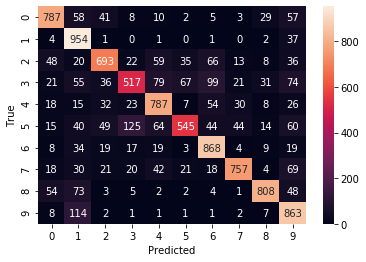

In [229]:
cr = classification_report(tests, preds)
print(f'Classification Report:\n {cr}')
cm = tf.math.confusion_matrix(labels=tests, predictions=preds, num_classes=10)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

In [230]:
# {0: 'plane',
#  1: 'car',
#  2: 'bird',
#  3: 'cat',
#  4: 'deer',
#  5: 'dog',
#  6: 'frog',
#  7: 'horse',
#  8: 'ship',
#  9: 'truck'}

In [245]:
def predict_label(model, labels, imagepath):

    img = tf.keras.preprocessing.image.load_img(os.path.join(imagepath), target_size=(32, 32))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, 0)      # Create batch axis (32, 32, 3) => (1, 32, 32, 3)

    predictions = model.predict(img_array)[0]
    index = np.argmax(predictions)
    result = labels[int(index)]
    imge = plt.imread(imagepath)
    plt.figure(figsize=(5, 5))
    plt.imshow(imge)
    plt.title(f'prediction: {result}')
    plt.xticks([])
    plt.yticks([])
    plt.show();
    return result

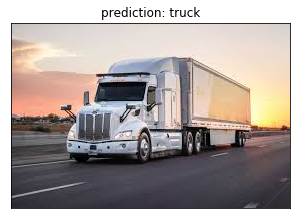

In [247]:
path = os.path.join(os.getcwd(), 'static\\uploads\\5.jpg')
result = predict_label(sn, LBL, path)